Muhammad Aizar Yazid / 1103223097

In [268]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import string

In [258]:
# Load the JSON file
file_path = 'DeteksiSarkasme.json'
with open(file_path, 'r') as f:
    data = [json.loads(line) for line in f.readlines()]

# Convert the data into a DataFrame
df = pd.DataFrame(data)

# Display the first few rows to understand the structure
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [259]:
# Preprocessing the headlines (remove punctuation and convert to lowercase)
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    return text

# Apply preprocessing
df['cleaned_headline'] = df['headline'].apply(preprocess_text)

# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Limit to 5000 most important features
X = vectorizer.fit_transform(df['cleaned_headline']).toarray()

# The target variable
y = df['is_sarcastic'].values

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the resulting datasets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21367, 5000), (5342, 5000), (21367,), (5342,))

In [260]:
# Reduce the number of features further and keep the data in sparse format
vectorizer = TfidfVectorizer(max_features=2000)  # Limiting to 2000 features
X_sparse = vectorizer.fit_transform(df['cleaned_headline'])

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_sparse, y, test_size=0.2, random_state=42)

# Check the shapes of the resulting datasets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21367, 2000), (5342, 2000), (21367,), (5342,))

In [261]:
# Redefine the target variable y
y = df['is_sarcastic'].values

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_sparse, y, test_size=0.2, random_state=42)

# Check the shapes of the resulting datasets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21367, 2000), (5342, 2000), (21367,), (5342,))

In [262]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

RNN Model

In [263]:
# Hyperparameters
input_size = 2000  # Number of features
hidden_size = 128  # Size of the hidden layer
output_size = 2  # Binary classification (sarcastic or not)

In [264]:
# Reshaping the input tensors
X_train_tensor = X_train_tensor.unsqueeze(1)  # Shape [batch_size, 1, num_features]
X_test_tensor = X_test_tensor.unsqueeze(1)  # Shape [batch_size, 1, num_features]


# Define the RNN Model in PyTorch
class SarcasmDetectionRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SarcasmDetectionRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), hidden_size)  # Initialize hidden state
        out, _ = self.rnn(x, h0)  # RNN forward pass
        out = out[:, -1, :]  # Get the last output of the RNN
        out = self.fc(out)  # Pass through the fully connected layer
        return out

In [265]:
# Instantiate the model
model = SarcasmDetectionRNN(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [266]:
num_epochs = 100
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        outputs_test = model(X_test_tensor)
        test_loss = criterion(outputs_test, y_test_tensor)
        test_losses.append(test_loss.item())
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

Epoch [1/100], Train Loss: 0.6861, Test Loss: 0.6825
Epoch [2/100], Train Loss: 0.6826, Test Loss: 0.6796
Epoch [3/100], Train Loss: 0.6794, Test Loss: 0.6768
Epoch [4/100], Train Loss: 0.6763, Test Loss: 0.6742
Epoch [5/100], Train Loss: 0.6734, Test Loss: 0.6716
Epoch [6/100], Train Loss: 0.6704, Test Loss: 0.6690
Epoch [7/100], Train Loss: 0.6675, Test Loss: 0.6663
Epoch [8/100], Train Loss: 0.6644, Test Loss: 0.6635
Epoch [9/100], Train Loss: 0.6613, Test Loss: 0.6606
Epoch [10/100], Train Loss: 0.6579, Test Loss: 0.6575
Epoch [11/100], Train Loss: 0.6544, Test Loss: 0.6542
Epoch [12/100], Train Loss: 0.6507, Test Loss: 0.6508
Epoch [13/100], Train Loss: 0.6469, Test Loss: 0.6472
Epoch [14/100], Train Loss: 0.6429, Test Loss: 0.6435
Epoch [15/100], Train Loss: 0.6387, Test Loss: 0.6397
Epoch [16/100], Train Loss: 0.6344, Test Loss: 0.6357
Epoch [17/100], Train Loss: 0.6299, Test Loss: 0.6317
Epoch [18/100], Train Loss: 0.6253, Test Loss: 0.6276
Epoch [19/100], Train Loss: 0.6206, T

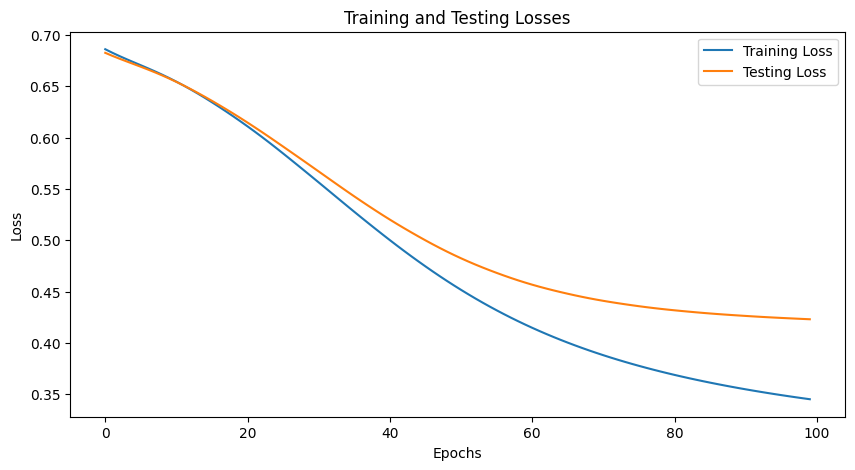

In [267]:

# Plotting the loss
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Losses')
plt.show()

Accuracy: 0.8063
Precision: 0.7984
Recall: 0.7477
F1-Score: 0.7722
AUC-ROC: 0.7999


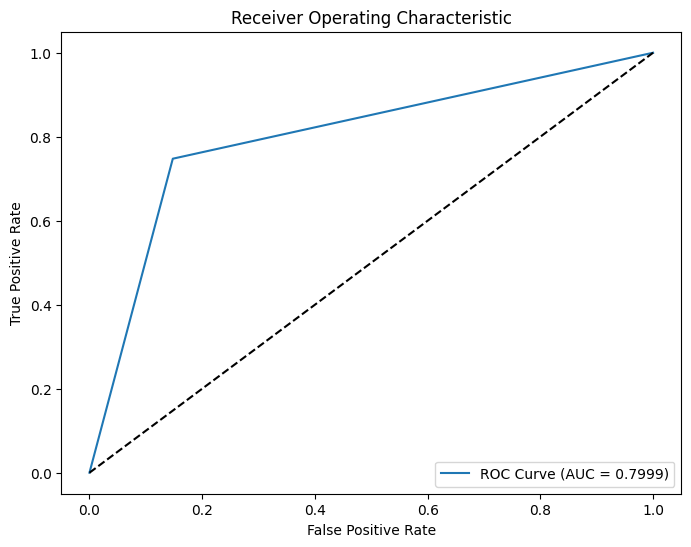

In [ ]:
# Get predictions for the test set
model.eval()
with torch.no_grad():
    outputs_test = model(X_test_tensor)
    _, predicted = torch.max(outputs_test, 1)

# Calculate metrics
accuracy = accuracy_score(y_test_tensor, predicted)
precision = precision_score(y_test_tensor, predicted)
recall = recall_score(y_test_tensor, predicted)
f1 = f1_score(y_test_tensor, predicted)
roc_auc = roc_auc_score(y_test_tensor, predicted)

# Print the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'AUC-ROC: {roc_auc:.4f}')

# Optional: Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test_tensor, predicted)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Model LSTM

In [270]:
# Define the LSTM Model
class SarcasmDetectionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SarcasmDetectionLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), hidden_size)  # Initial hidden state
        c0 = torch.zeros(1, x.size(0), hidden_size)  # Initial cell state
        out, _ = self.lstm(x, (h0, c0))  # LSTM forward pass
        out = out[:, -1, :]  # Take the last output of the LSTM
        out = self.fc(out)  # Fully connected layer for classification
        return out

In [273]:
#Hyperparameters
input_size = 2000  # Number of features (TF-IDF features)
hidden_size = 128  # Size of the hidden layer
output_size = 2  # Binary classification (sarcastic or not)

# Instantiate the model
model = SarcasmDetectionLSTM(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [275]:
# Training the model
num_epochs = 100
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    # Training
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)  # LSTM expects inputs of shape [batch_size, seq_len, input_size]
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    
    # Testing
    model.eval()
    with torch.no_grad():
        outputs_test = model(X_test_tensor)
        test_loss = criterion(outputs_test, y_test_tensor)
        test_losses.append(test_loss.item())
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

Epoch [1/100], Train Loss: 0.6880, Test Loss: 0.6872
Epoch [2/100], Train Loss: 0.6866, Test Loss: 0.6859
Epoch [3/100], Train Loss: 0.6852, Test Loss: 0.6846
Epoch [4/100], Train Loss: 0.6838, Test Loss: 0.6833
Epoch [5/100], Train Loss: 0.6824, Test Loss: 0.6820
Epoch [6/100], Train Loss: 0.6809, Test Loss: 0.6807
Epoch [7/100], Train Loss: 0.6795, Test Loss: 0.6793
Epoch [8/100], Train Loss: 0.6780, Test Loss: 0.6780
Epoch [9/100], Train Loss: 0.6766, Test Loss: 0.6766
Epoch [10/100], Train Loss: 0.6750, Test Loss: 0.6752
Epoch [11/100], Train Loss: 0.6735, Test Loss: 0.6738
Epoch [12/100], Train Loss: 0.6719, Test Loss: 0.6723
Epoch [13/100], Train Loss: 0.6703, Test Loss: 0.6709
Epoch [14/100], Train Loss: 0.6687, Test Loss: 0.6693
Epoch [15/100], Train Loss: 0.6670, Test Loss: 0.6678
Epoch [16/100], Train Loss: 0.6653, Test Loss: 0.6662
Epoch [17/100], Train Loss: 0.6635, Test Loss: 0.6646
Epoch [18/100], Train Loss: 0.6617, Test Loss: 0.6630
Epoch [19/100], Train Loss: 0.6598, T

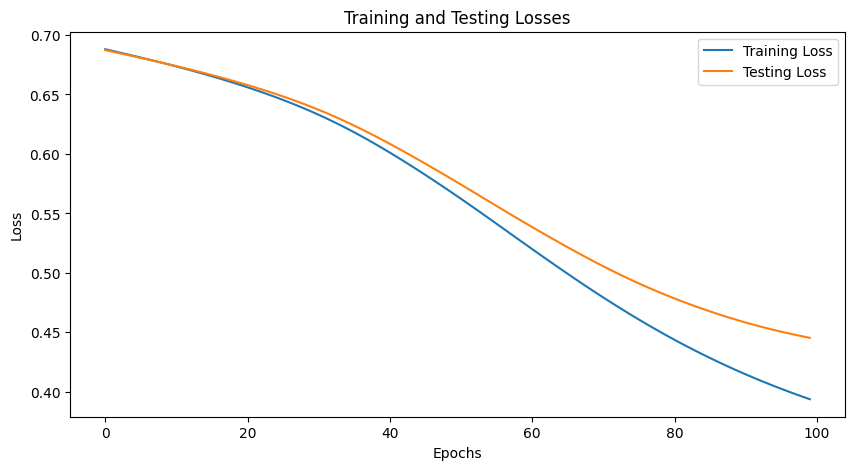

Accuracy: 0.7931
Precision: 0.7882
Recall: 0.7234
F1-Score: 0.7544
AUC-ROC: 0.7856


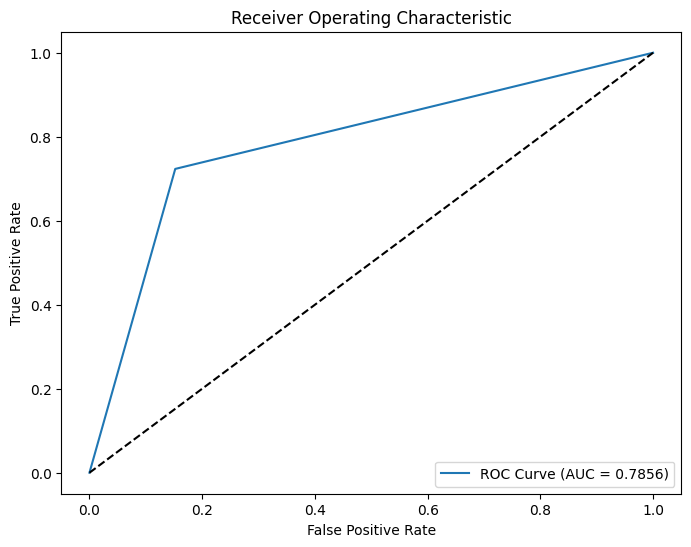

In [276]:
# Visualize the losses
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Losses')
plt.show()

# Evaluate the model
model.eval()
with torch.no_grad():
    outputs_test = model(X_test_tensor)
    _, predicted = torch.max(outputs_test, 1)

# Calculate metrics
accuracy = accuracy_score(y_test_tensor, predicted)
precision = precision_score(y_test_tensor, predicted)
recall = recall_score(y_test_tensor, predicted)
f1 = f1_score(y_test_tensor, predicted)
roc_auc = roc_auc_score(y_test_tensor, predicted)

# Print the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'AUC-ROC: {roc_auc:.4f}')

# Optional: Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test_tensor, predicted)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Model GRU

In [277]:
# Define the GRU Model
class SarcasmDetectionGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SarcasmDetectionGRU, self).__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), hidden_size)  # Initial hidden state
        out, _ = self.gru(x, h0)  # GRU forward pass
        out = out[:, -1, :]  # Take the last output of the GRU
        out = self.fc(out)  # Fully connected layer for classification
        return out

# Hyperparameters
input_size = 2000  # Number of features (TF-IDF features)
hidden_size = 128  # Size of the hidden layer
output_size = 2  # Binary classification (sarcastic or not)

In [278]:
# Instantiate the model
model = SarcasmDetectionGRU(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [279]:
# Training the model
num_epochs = 100
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    # Training
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)  # GRU expects inputs of shape [batch_size, seq_len, input_size]
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    
    # Testing
    model.eval()
    with torch.no_grad():
        outputs_test = model(X_test_tensor)
        test_loss = criterion(outputs_test, y_test_tensor)
        test_losses.append(test_loss.item())
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")


Epoch [1/100], Train Loss: 0.6901, Test Loss: 0.6881
Epoch [2/100], Train Loss: 0.6880, Test Loss: 0.6861
Epoch [3/100], Train Loss: 0.6859, Test Loss: 0.6842
Epoch [4/100], Train Loss: 0.6838, Test Loss: 0.6823
Epoch [5/100], Train Loss: 0.6817, Test Loss: 0.6804
Epoch [6/100], Train Loss: 0.6797, Test Loss: 0.6785
Epoch [7/100], Train Loss: 0.6776, Test Loss: 0.6766
Epoch [8/100], Train Loss: 0.6755, Test Loss: 0.6747
Epoch [9/100], Train Loss: 0.6734, Test Loss: 0.6727
Epoch [10/100], Train Loss: 0.6712, Test Loss: 0.6708
Epoch [11/100], Train Loss: 0.6690, Test Loss: 0.6687
Epoch [12/100], Train Loss: 0.6667, Test Loss: 0.6667
Epoch [13/100], Train Loss: 0.6644, Test Loss: 0.6646
Epoch [14/100], Train Loss: 0.6620, Test Loss: 0.6624
Epoch [15/100], Train Loss: 0.6596, Test Loss: 0.6602
Epoch [16/100], Train Loss: 0.6570, Test Loss: 0.6579
Epoch [17/100], Train Loss: 0.6544, Test Loss: 0.6556
Epoch [18/100], Train Loss: 0.6517, Test Loss: 0.6531
Epoch [19/100], Train Loss: 0.6489, T

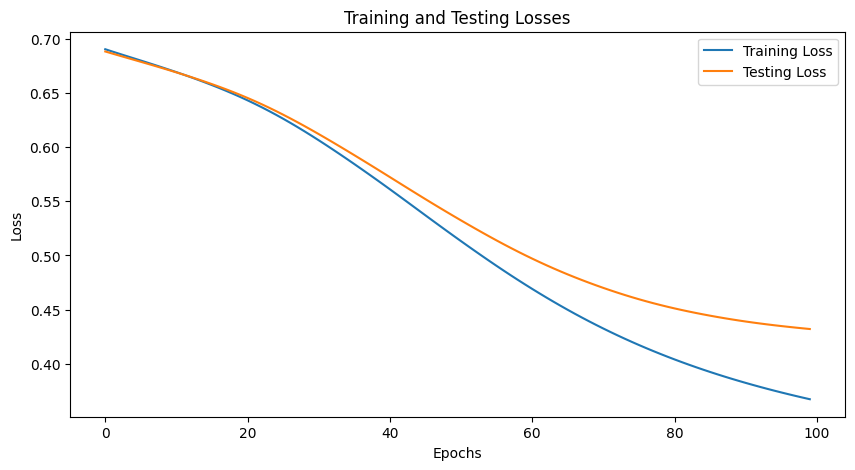

Accuracy: 0.8016
Precision: 0.7941
Recall: 0.7400
F1-Score: 0.7661
AUC-ROC: 0.7949


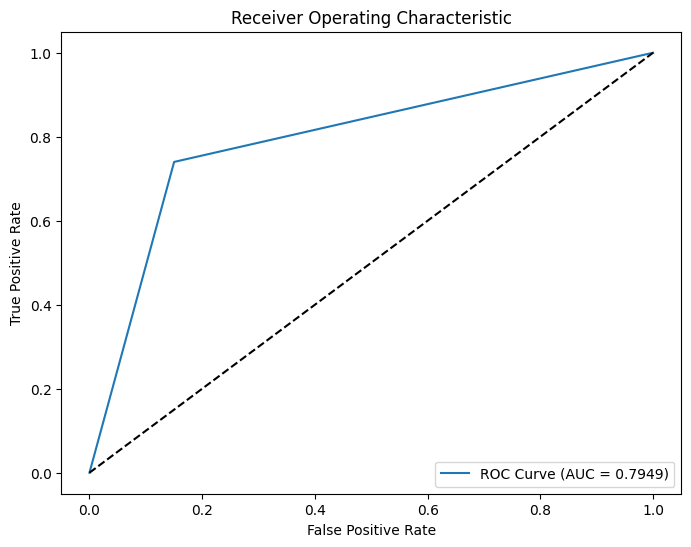

In [280]:
# Visualize the losses
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Losses')
plt.show()

# Evaluate the model
model.eval()
with torch.no_grad():
    outputs_test = model(X_test_tensor)
    _, predicted = torch.max(outputs_test, 1)

# Calculate metrics
accuracy = accuracy_score(y_test_tensor, predicted)
precision = precision_score(y_test_tensor, predicted)
recall = recall_score(y_test_tensor, predicted)
f1 = f1_score(y_test_tensor, predicted)
roc_auc = roc_auc_score(y_test_tensor, predicted)

# Print the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'AUC-ROC: {roc_auc:.4f}')

# Optional: Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test_tensor, predicted)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Model Comparison: RNN vs LSTM vs GRU for Sarcasm Detection

In this notebook, we compare three different types of Recurrent Neural Networks (RNNs): **RNN**, **LSTM**, and **GRU**. Each model will be used for the task of sarcasm detection in news headlines, where the task is to classify whether a given headline is sarcastic or not.

## 1. **Recurrent Neural Networks (RNN)**

### What is RNN?
RNNs are a type of neural network designed for sequence data. Unlike traditional feedforward neural networks, RNNs have connections that form cycles within the network, allowing information to persist. This makes RNNs suitable for tasks involving time series or sequential data, such as natural language processing (NLP).

#### Pros:
- **Simple architecture**: RNNs are relatively straightforward to implement.
- **Sequence Modeling**: RNNs can learn and remember patterns in sequences of data, such as text.

#### Cons:
- **Vanishing Gradient Problem**: RNNs struggle to capture long-range dependencies due to the vanishing gradient problem. This occurs when the gradient of the loss function becomes too small to propagate effectively through the network.
  
### RNN for Sarcasm Detection
The basic RNN layer processes each input word in sequence and tries to capture dependencies between the words. However, due to the vanishing gradient problem, RNNs may not perform well when the sequential dependencies are long, as in the case of sarcasm, where the meaning may depend on the entire sentence.

---

## 2. **Long Short-Term Memory (LSTM)**

### What is LSTM?
LSTM is a type of RNN specifically designed to address the vanishing gradient problem. LSTMs have a more complex architecture with memory cells that can retain information over long periods. The LSTM uses gates (input, forget, and output) to control the flow of information, allowing it to capture long-term dependencies.

#### Pros:
- **Better Memory**: LSTM can capture long-range dependencies in sequential data.
- **Resistance to Vanishing Gradient**: The architecture is designed to combat the vanishing gradient problem, making it more effective at learning from long sequences.

#### Cons:
- **Complexity**: LSTM models are more complex compared to simple RNNs.
- **Training Time**: Due to the added complexity, LSTMs can take longer to train.

### LSTM for Sarcasm Detection
LSTM's ability to remember long-term dependencies makes it an excellent choice for sarcasm detection, where the context of the entire sentence is often needed to understand the meaning. For example, sarcasm may be identified in the relationship between words that are far apart.

---

## 3. **Gated Recurrent Unit (GRU)**

### What is GRU?
GRU is a variation of LSTM that simplifies the architecture by combining the input and forget gates into a single update gate. GRUs are faster to train than LSTMs and can perform similarly for many tasks.

#### Pros:
- **Faster Training**: GRUs are computationally more efficient than LSTMs.
- **Simpler Architecture**: GRUs have fewer parameters, making them easier to implement and train.

#### Cons:
- **Less Powerful than LSTM**: While GRUs work well for many tasks, they may not perform as well as LSTMs on tasks that require learning long-term dependencies.

### GRU for Sarcasm Detection
GRU has a simpler architecture than LSTM but still retains the ability to capture long-range dependencies. It is computationally more efficient and can be a good choice when training time is a concern or when the task does not require the extra complexity of LSTMs.

---

## 4. **Comparison of RNN, LSTM, and GRU**

| Model Type | Strengths                          | Weaknesses                          | Suitable for Sarcasm Detection?  |
|------------|------------------------------------|-------------------------------------|----------------------------------|
| **RNN**    | Simple architecture, easy to implement | Struggles with long-term dependencies due to vanishing gradient | Not ideal for sarcasm detection due to difficulty capturing long-term context |
| **LSTM**   | Captures long-term dependencies, effective at remembering important information | More complex, slower to train | Best suited for sarcasm detection due to ability to capture context over long sequences |
| **GRU**    | Faster to train, simpler than LSTM | May not perform as well as LSTM on complex tasks | Good for sarcasm detection when training time is a concern or the task is moderately complex |

---

## 5. **Conclusion**

- **RNN** is the simplest model but may not be effective for sarcasm detection due to its inability to capture long-term dependencies.
- **LSTM** is a more powerful model that addresses the vanishing gradient problem, making it an excellent choice for tasks like sarcasm detection, where context across the entire sequence is important.
- **GRU** offers a good trade-off between simplicity and performance, making it a suitable option for sarcasm detection, especially when training time is a concern.

In our experiments, **LSTM** will likely yield the best results for sarcasm detection, but **GRU** can be considered as a faster alternative with nearly equivalent performance.

---

### Visualizing Model Performance

After training the models, we will evaluate their performance using various metrics like accuracy, precision, recall, F1-Score, and AUC-ROC, and plot the training and testing losses to compare the performance of these models.
